<a href="https://colab.research.google.com/github/cksdlakstp12/deep_learning_study/blob/main/torch_basic_for_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

import torchvision
import torchvision.transforms as tr
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from tqdm import tqdm

import imageio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import copy
import urllib.request

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/models/torch_basic_study"

# Meta Learning

## Meta Learning and Few-shot Learning

### Meta Learning
- 메타 데이터라고 불리는 방대한 데이터를 이용해 학습하는 방법을 학습하여 적은 데이터로도 새로운 문제를 빠르게 풀 수 있게 하는 방법론

### Few-shot Learning
- 적은 양의 데이터를 가진 여러 가지 업무 세트가 존재할 때 그 업무 세트를 사지고 학습하는 방법을 학습하여 새로운 업무에 대해서 적은 양의 데이터라도 빠르게 학습할 수 있는 메타 학습 방법 중 하나

### MAML : Model-Agnostic Meta-Learning
- 최적화 기반 메타 학습(Optimization-based Meta-Learning) 중 하나로 메타 훈련 데이터를 통해 어떤 식으로 모델을 최적화해야 일반적인 모델 파라미터를 얻을 수 있는지를 학습하는 방법

## MAML regression

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class TensorData(Dataset):
  def __init__(self, x_data, y_data):
    self.x_data = x_data
    self.y_data = y_data
    self.len = self.y_data.shape[0]
  
  def __getitem__(self, index):
    return self.x_data[index], self.y_data[index]
  
  def __len__(self):
    return self.len

class SinusoidalFunction:
  def __init__(self, x_range=5, k=5, num_tasks=4):
    self.x_range = x_range
    self.pi = torch.acos(torch.zeros(1)).item() * 2
    self.k = k
    self.num_tasks = num_tasks

  def meta_train_data(self):
    x_points = 2 * self.x_range * (torch.rand((self.num_tasks, 2 * self.k)) - 0.5)
    y_points = torch.tensor([], dtype=torch.float)
    for x in x_points:
      a = 4 * (torch.rand(1) + 0.1)
      b = self.pi * torch.rand(1)
      y = a * torch.sin(x.view(1, -1)+ b)
      y_points = torch.cat((y_points, y), 0)
    taskset = TensorData(x_points, y_points)
    trainloader = DataLoader(taskset, batch_size=1)
    return trainloader

  def meta_eval_data(self, k):
    x_points = 2 * self.x_range * (torch.rand(2 * k) - 0.5)
    a = 4 * (torch.rand(1) + 0.1)
    b = self.pi * torch.rand(1)
    y_points = a * torch.sin(x_points+ b)
    sup_x = x_points[:k]
    sup_y = y_points[:k]
    que_x = x_points[k:]
    que_y = y_points[k:]
    x = torch.linspace(-self.x_range, self.x_range, 200)
    y = a * torch.sin(x + b)
    return sup_x, sup_y, que_x, que_y, x, y

In [ ]:
k = 5
num_tasks = 2000
sine = SinusoidalFunction(k=k, num_tasks=num_tasks)
trainloader = sine.meta_train_data()

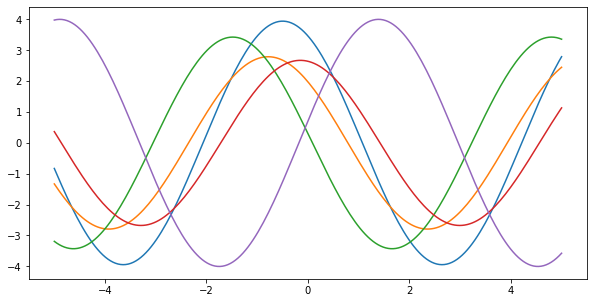

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(5):
  _, _, _, _, x, y = sine.meta_eval_data(5)
  plt.plot(x, y)
plt.show()
plt.close()

In [ ]:
class Regressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(1, 40)
    self.fc2 = nn.Linear(40, 40)
    self.fc3 = nn.Linear(40, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return self.fc3(x)

  def parameterised(self, x, weights):
    x = F.relu(F.linear(x, weights[0], weights[1]))
    x = F.relu(F.linear(x, weights[2], weights[3]))
    x = F.linear(x, weights[4], weights[5])
    return x

class MAML:
  def __init__(self, trainloader, k, alpha=1e-2, beta=1e-3):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.k = k
    self.model = Regressor().to(device)
    self.weights = list(self.model.parameters())
    self.trainloader = trainloader
    self.beta = beta
    self.criterion = nn.MSELoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=alpha)
  
  def inner_loop(self, data):
    temp_weights = [w.clone() for w in self.weights]
    inputs, values = data[0].to(device), data[1].to(device)
    support_x = inputs[:, :self.k].T
    support_y = values[:, :self.k].T
    query_x = inputs[:, self.k:].T
    query_y = values[:, self.k:].T

    outputs = self.model.parameterised(support_x, temp_weights)
    loss = self.criterion(outputs, support_y)
    grad = torch.autograd.grad(loss, temp_weights)
    tmp = [w - self.beta * g for w, g in zip(temp_weights, grad)]
    outputs = self.model.parameterised(query_x, tmp)
    inner_loss = self.criterion(outputs, query_y)
    return inner_loss

  def meta_train(self, num_epochs):
    n = len(self.trainloader)
    loss_list = []
    for epoch in range(num_epochs):
      self.optimizer.zero_grad()
      outer_loss = 0

      for data in self.trainloader:
        outer_loss += self.inner_loop(data)

      avg_loss = outer_loss / n
      avg_loss.backward()
      self.optimizer.step()
      ll = avg_loss.item()
      loss_list.append(ll)
      if epoch % 10 == 0:
        print(epoch, ll)

    return loss_list

In [ ]:
maml = MAML(trainloader, k=k)
loss = maml.meta_train(201)

0 3.5039281845092773
10 3.0522537231445312
20 2.9045772552490234
30 2.7688496112823486
40 2.6424365043640137
50 2.5388615131378174
60 2.469054937362671
70 2.4234564304351807
80 2.3804056644439697
90 2.3560030460357666
100 2.3406877517700195
110 2.325392007827759
120 2.3060171604156494
130 2.2906415462493896
140 2.2742013931274414
150 2.2525634765625
160 2.225719451904297
170 2.188523530960083
180 2.0982563495635986
190 2.0096282958984375
200 1.904884934425354


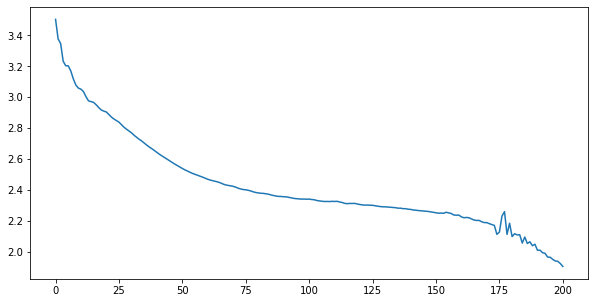

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(loss)
plt.show()

In [ ]:
def inference(sup_x, sup_y, x, y, model):
  with torch.no_grad():
    pred = model(x.view(-1, 1).to(device))
    plt.figure(figsize=(10, 5))
    plt.plot(x.cpu().detach(), pred.cpu().detach(), "-b")
    plt.plot(sup_x.cpu().detach(), sup_y.cpu().detach(), ".g")
    plt.plot(x, y, "--r")
    plt.legend(["prediction", "actual points", "actual graph"])
    plt.show()
    plt.close()

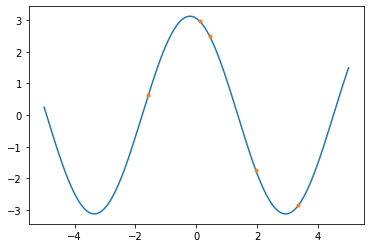

In [ ]:
sup_x, sup_y, _, _, x, y = sine.meta_eval_data(5)
plt.plot(x, y)
plt.plot(sup_x, sup_y, ".")
plt.show()

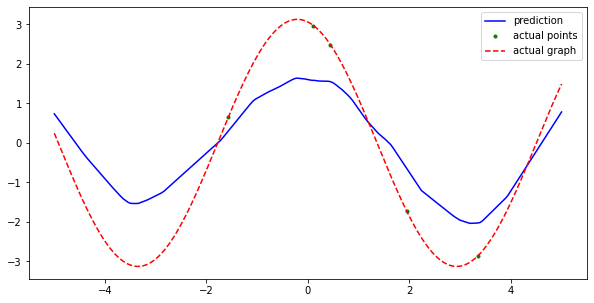

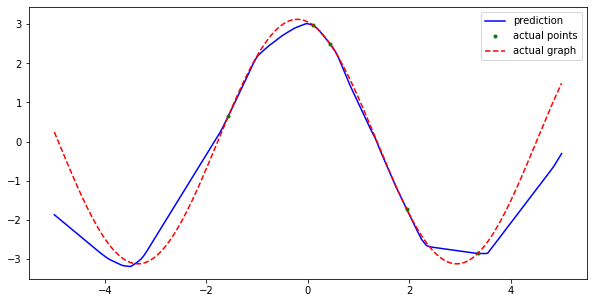

In [ ]:
pre = maml.model
criterion = nn.MSELoss()
optimizer = optim.Adam(pre.parameters(), lr=1e-3)
num_epochs = 501
for i in range(num_epochs):
  optimizer.zero_grad()
  outputs = pre(sup_x.view(-1, 1).to(device))
  loss = criterion(outputs, sup_y.view(-1, 1).to(device))
  loss.backward()
  optimizer.step()
  if i == 0:
    inference(sup_x, sup_y, x, y, pre)
  elif i == num_epochs - 1:
    inference(sup_x, sup_y, x, y, pre)

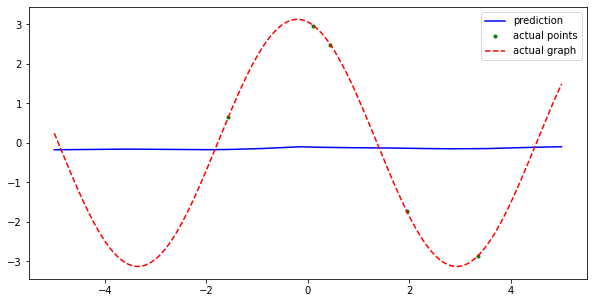

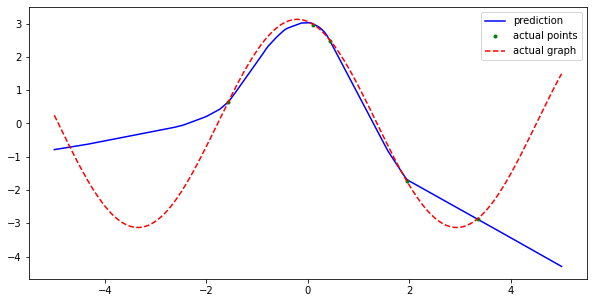

In [ ]:
net = Regressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

for i in range(num_epochs):
  optimizer.zero_grad()
  outputs = net(sup_x.view(-1, 1).to(device))
  loss = criterion(outputs, sup_y.view(-1, 1).to(device))
  loss.backward()
  optimizer.step()
  if i == 0:
    inference(sup_x, sup_y, x, y, net)
  elif i == num_epochs - 1:
    inference(sup_x, sup_y, x, y, net)

## MAML Classification

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class MyTransform:
  def __call__(self, sample, mode):
    inputs1, inputs2, labels = sample
    if mode == "train":
      transf = tr.RandomHorizontalFlip()
      output1 = transf(inputs1)  
    else:
      output1 = inputs1
    return output1, inputs2, labels

class TensorData(Dataset):
  def __init__(self, support_set, query_set, labels, mode="train"):
    self.support_set = torch.FloatTensor(support_set).permute(0, 3, 1, 2)
    self.query_set = torch.FloatTensor(query_set).permute(0, 3, 1, 2)
    self.labels = torch.LongTensor(labels)
    self.len = self.labels.shape[0]
    self.transform = MyTransform()
    self.mode = mode

  def __getitem__(self, index):
    sample = self.support_set[index], self.query_set[index], self.labels[index]
    sample = self.transform(sample, self.mode)
    return sample
  
  def __len__(self):
    return self.len

class CIFAR100DataSet:
  def __init__(self, Nway=5, fewshot=5):
    self.cifar = torchvision.datasets.CIFAR100(root="./data", train=True, download=True)
    self.Nway = Nway
    self.fewshot = fewshot
  
  def task_generator(self, cls, mode="train"):
    labels = np.array(self.cifar.targets)
    data = self.cifar.data / 255
    support_set = []
    query_set = []
    targets = []

    for i, c in enumerate(cls):
      idx = np.where(labels == c)[0]
      rand = np.random.choice(len(idx), 2*self.fewshot, replace=False)
      for shot in range(2*self.fewshot):
        img = data[idx[rand[shot]]]

        if shot < self.fewshot:
          support_set.append(img)
          targets.append(i)

        else:
          query_set.append(img)
    
    support_set = np.stack(support_set)
    query_set = np.stack(query_set)
    targets = np.array(targets)
    taskset = TensorData(support_set, query_set, targets, mode=mode)
    dataloader = DataLoader(taskset, batch_size=self.Nway*self.fewshot, shuffle=False)
    return dataloader
  
  def task_set(self, num_tasks, cls, mode="train"):
    task_collection = []
    for i in range(num_tasks):
      task_collection.append(self.task_generator(cls, mode=mode))
    return task_collection

In [ ]:
Nway = 5
fewshot = 5

In [ ]:
cifar100 = CIFAR100DataSet(Nway=Nway, fewshot=fewshot)
trainloader = cifar100.task_generator(cls=[0, 10, 20, 50, 70])
data1, data2, label = iter(trainloader).next()
print(data1.size(), data2.size(), label.size())

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
torch.Size([25, 3, 32, 32]) torch.Size([25, 3, 32, 32]) torch.Size([25])


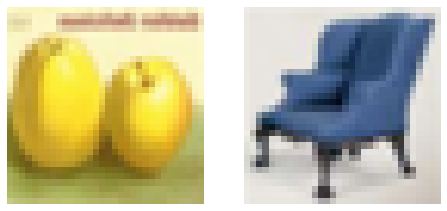

In [ ]:
oneshot1 = data1[0].permute(1, 2, 0).numpy()
oneshot2 = data2[10].permute(1, 2, 0).numpy()
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(oneshot1)
plt.axis("off")
plt.subplot(132)
plt.imshow(oneshot2)
plt.axis("off")
plt.show()

In [ ]:
class CNN(nn.Module):
  def __init__(self, Nway):
    super(CNN, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 64, 3), nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(64, 128, 3, stride=1, padding=1), nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(128, 256, 3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(256, 256, 3, stride=1), nn.ReLU(),
        nn.Conv2d(256, 256, 3, stride=1), nn.ReLU())
    self.classifier = nn.Sequential(
        nn.Linear(256, 128), nn.ReLU(), 
        nn.Linear(128, Nway))
  
  def forward(self, x):
    x = self.features(x)
    x = torch.mean(x, [2, 3])
    x = self.classifier(x)
    return x

  def parameterised(self, x, weights):
    x = F.relu(F.conv2d(x, weight=weights[0], bias=weights[1], stride=1))
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    x = F.relu(F.conv2d(x, weight=weights[2], bias=weights[3], stride=1, padding=1))
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    x = F.relu(F.conv2d(x, weight=weights[4], bias=weights[5], stride=1, padding=1))
    x = F.relu(F.conv2d(x, weight=weights[6], bias=weights[7], stride=1))
    x = F.relu(F.conv2d(x, weight=weights[8], bias=weights[9], stride=1))
    x = torch.mean(x, [2, 3])
    x = F.relu(F.linear(x, weights[10], weights[11]))
    x = F.linear(x, weights[12], weights[13])
    return x

class MAML:
  def __init__(self, num_tasks=300, Nway=5, alpha=1e-3, beta=1e-3, inner_steps=1, cls=None):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.num_tasks = num_tasks
    self.model = CNN(Nway).to(device)
    self.weights = list(self.model.parameters())
    self.beta = beta
    self.cifar100 = CIFAR100DataSet()
    self.task_collection = self.cifar100.task_set(num_tasks=self.num_tasks, cls=cls[:60], mode="train")
    self.meta_val_set = self.cifar100.task_set(num_tasks=30, cls=cls[60:], mode="val")
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=alpha, weight_decay=1e-4)
    self.inner_steps = inner_steps

  def inner_loop(self, dataloader):
    temp_weights = [w.clone() for w in self.weights]
    data = iter(dataloader).next()
    support, query, label = data[0].to(device), data[1].to(device), data[2].to(device)
    for i in range(self.inner_steps):
      outputs = self.model.parameterised(support, temp_weights)
      loss = self.criterion(outputs, label)
      grad = torch.autograd.grad(loss, temp_weights)
      temp_weights = [w - self.beta * g for w, g in zip(temp_weights, grad)]
    outputs = self.model.parameterised(query, temp_weights)
    inner_loss = self.criterion(outputs, label)
    return inner_loss

  def meta_train(self, num_epochs):
    loss_list = []
    acc = 0
    for epoch in range(num_epochs):
      self.optimizer.zero_grad()
      outer_loss = 0
      for i in range(self.num_tasks):
        outer_loss += self.inner_loop(self.task_collection[i])
      avg_loss = outer_loss / self.num_tasks
      avg_loss.backward()
      self.optimizer.step()
      ll = avg_loss.item()
      loss_list.append(ll)
      val_acc = self.meta_val()
      if epoch % 10 == 0:
        print("[%d] Train loss: %.3f, Validation accuracy: %.2f %%" %(epoch, ll, val_acc))
      if val_acc >= acc:
        acc = val_acc
        print("Saved the model - Validation accuracy: %.2f %%" %(val_acc))
        torch.save(self.model.state_dict(), f"{MODEL_SAVE_PATH}/cifar_maml.pt")
    return loss_list

  def meta_val(self):
    acc_list = []
    for i in range(len(self.meta_val_set)):
      cnn = copy.deepcopy(self.model)
      criterion = nn.CrossEntropyLoss()
      opt = optim.Adam(cnn.parameters(), lr=1e-2)
      num_epochs = 101
      testloader = self.meta_val_set[i]
      data1, data2, label = iter(testloader).next()
      cnn.train()
      for j in range(num_epochs):
        opt.zero_grad()
        outputs = cnn(data1.to(device))
        loss = criterion(outputs, label.to(device))
        loss.backward()
        opt.step()
      correct = 0
      total = 0
      with torch.no_grad():
        cnn.eval()
        outputs = cnn(data2.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label.to(device)).sum().item()
      acc_list.append(100 * correct / total)
    acc_info = np.array(acc_list)
    avg_acc = np.mean(acc_info)
    return avg_acc

In [ ]:
cls = np.random.choice(range(0, 100), 100, replace=False)
maml = MAML(num_tasks=300, Nway=5, cls=cls[:80])
loss = maml.meta_train(501)

Files already downloaded and verified
[0] Train loss: 1.610, Validation accuracy: 31.87 %
Saved the model - Validation accuracy: 31.87 %
Saved the model - Validation accuracy: 33.07 %
[10] Train loss: 1.357, Validation accuracy: 29.73 %


In [ ]:
def meta_test(task_collection, pretrained=None):
  acc_list = []
  for i in range(len(task_collection)):
    cnn = CNN(Nway).to(device)
    if pretrained == "meta":
      cnn.oad_state_dict(torch.load(f"{MODEL_SAVE_PATH}/cifar_maml.pt"))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=1e-2)
    num_epochs = 101
    testloader = task_collection[i]
    data1, data2, label = iter(testloader).next()

    cnn.train()
    for j in range(num_epochs):
      optimizer.zero_grad()
      outputs = cnn(data1.to(device))
      loss = criterion(outputs, label.to(device))
      loss.backward()
      optimizer.step()

    correct = 0
    total = 0
    with torch.no_grad():
      cnn.eval()
      outputs = cnn(data2.to(device))
      _, predicted = torch.max(outputs.data, 1)
      total += label.size(0)
      correct += (predicted == label.to(device)).sum().item()
    acc_list.append(100 * correct / total)
  acc_info = np.array(acc_list)
  print("Avg. Test accuracy: %.2f %% ± %.2f" % (np.mean(acc_info), 1.96*np.std(acc_info)/np.sqrt(len(acc_info))))

In [ ]:
meta_test_set = cifar100.task_set(num_tasks=100, cls=cls[80:])
meta_test(meta_test_set, "meta")

In [ ]:
meta_test(meta_test_set)